In [1]:
# import os
# import tensorflow as tf

# # Set CUDA device order and visible devices
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7,8,9"

# # Set the device
# device = '/cpu:0'
# if tf.config.experimental.list_physical_devices('GPU'):
#     try:
#         # Restrict TensorFlow to only use the second GPU
#         gpus = tf.config.experimental.list_physical_devices('GPU')
#         if gpus:
#             tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#             device = '/gpu:0'
#     except RuntimeError as e:
#         print(e)

# print("device", device)


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"  # Only GPUs 0 and 1 will be visible to TensorFlow

import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1","/gpu:2"])
# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

2024-09-28 20:33:34.095494: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-28 20:33:34.109498: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-28 20:33:34.122907: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-28 20:33:34.126976: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-28 20:33:34.138594: I tensorflow/core/platform/cpu_feature_guar

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


2024-09-28 20:33:36.380022: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:45:00.0, compute capability: 8.0
2024-09-28 20:33:36.381460: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79194 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:46:00.0, compute capability: 8.0
2024-09-28 20:33:36.383726: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 79194 MB memory:  -> device: 2, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:49:00.0, compute capability: 8.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import h5py
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks


In [3]:

# -----------------------------
# DataLoader Class Definition
# -----------------------------
class DataLoader:
    def __init__(self, h5_filename):
        self.h5_filename = h5_filename
        self.images, self.centers = self.load_data()

    def load_data(self):
        with h5py.File(self.h5_filename, 'r') as f:
            images = np.array(f['images'])
            centers = np.array(f['centers_training'])
        return images, centers

    def plot_image_with_centers(self, image_index=None):
        if image_index is None:
            image_index = np.random.randint(0, len(self.images))

        image = self.images[image_index]
        centers = self.centers[image_index]

        plt.imshow(image, cmap='gray')
        valid_centers = centers[centers[:, 0] == 1]
        for center in valid_centers:
            plt.scatter(center[1], center[2], c='red', marker='x')  # center[1] is x and center[2] is y
        plt.title('Image with Valid Centers Marked')
        plt.colorbar()
        plt.show()

    @staticmethod
    def sort_centers(centers):
        return centers[np.lexsort((centers[:, 0], centers[:, 1]))]

    def normalize_data(self):
        normalized_images = self.images / np.max(self.images)
        sorted_centers = np.array([self.sort_centers(image_centers[:, 1:]) for image_centers in self.centers])
        normalized_centers = sorted_centers / 64

        normalized_midpoints = tf.expand_dims(normalized_centers, axis=1)
        return normalized_images, normalized_midpoints.numpy()

    def split_data(self, train_size=0.8, random_state=42):
        normalized_images, normalized_midpoints_np = self.normalize_data()
        return train_test_split(normalized_images, normalized_midpoints_np, train_size=train_size, random_state=random_state)


In [4]:

# -----------------------------
# Utility Function Definition
# -----------------------------
def plot_transposed_images_with_midpoints(dataset, image_indices=[0, 1, 2, 3]):
    """
    Extracts multiple images and their midpoints from the given dataset, transposes the images, 
    corrects the midpoints, and plots the transposed images with the corrected midpoints.

    Args:
    - dataset (tf.data.Dataset): The dataset from which to extract the images and midpoints.
    - image_indices (list): The indices of the images in the batch to visualize. Default is [0, 1, 2, 3].
    """

    # Extract a sample image batch and its corresponding midpoints from the dataset
    sample_image_batch, sample_midpoints_batch = next(iter(dataset))

    # Create a figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))

    for i, ax in enumerate(axes.flat):
        if i < len(image_indices):
            # Select the specified image and corresponding midpoints from the batch
            sample_image = np.array(sample_image_batch[image_indices[i]])
            sample_midpoints = np.array(sample_midpoints_batch[image_indices[i]])

            # Transpose the image
            transposed_image = sample_image.T

            # Correct the midpoints by swapping the x and y coordinates
            transposed_midpoints_corrected = sample_midpoints[:, :, [1, 0]]

            # Plot the transposed image with corrected midpoints
            ax.imshow(transposed_image, cmap='gray')
            ax.scatter(
                transposed_midpoints_corrected[:, :, 0] * 64, 
                transposed_midpoints_corrected[:, :, 1] * 64, 
                c='red', marker='o', s=5
            )
            ax.set_title(f'Image {image_indices[i]} for this batch')
        else:
            ax.axis('off')  # If fewer than 4 images are requested, hide the unused subplots

    plt.tight_layout()
    plt.show()

# -----------------------------
# Custom Loss and Callback Definitions
# -----------------------------
@tf.keras.utils.register_keras_serializable()
def custom_loss(exponent):
    def loss(y_true, y_pred):
        diff = tf.abs(y_true - y_pred)
        powered_diff = tf.pow(diff, exponent)
        return tf.reduce_mean(powered_diff)
    return loss

@tf.keras.utils.register_keras_serializable()
class DynamicExponentCallback(tf.keras.callbacks.Callback):
    def __init__(self, initial_exponent, increment, update_frequency):
        super().__init__()
        self.exponent = initial_exponent
        self.increment = increment
        self.update_frequency = update_frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.update_frequency == 0:
            self.exponent += self.increment
            print(f"\nEpoch {epoch + 1}: Increasing exponent to {self.exponent}")
            self.model.loss = self.custom_loss(self.exponent)

    def custom_loss(self, exponent):
        def loss(y_true, y_pred):
            diff = tf.abs(y_true - y_pred)
            powered_diff = tf.pow(diff, exponent)
            return tf.reduce_mean(powered_diff)
        return loss

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'initial_exponent': self.exponent,
            'increment': self.increment,
            'update_frequency': self.update_frequency,
        })
        return config


my NEW model

In [5]:
from tensorflow.keras import layers, regularizers

class ModelBuilder:
    def __init__(self, input_shape=(64, 64, 1), num_classes=5, num_coordinates=2, learning_rate=3e-5, weights_path=None, l2_reg=0.001):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_coordinates = num_coordinates
        self.learning_rate = learning_rate
        self.l2_reg = l2_reg
        self.model = self.build_model()

        # Load weights if a path is provided
        if weights_path is not None:
            self.model.load_weights(weights_path)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # self.optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

    def build_model(self):
        l2 = regularizers.l2(self.l2_reg)
        
        x_input = layers.Input(shape=self.input_shape)
        
        # First branch
        x_1 = layers.Conv2D(64, kernel_size=6, strides=1, padding='same', activation='relu')(x_input)
        x_1 = layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(x_1)
        x_1 = layers.Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu')(x_1)
        x_1 = layers.Conv2D(16, kernel_size=3, strides=3, padding='same', activation='relu', kernel_regularizer=l2)(x_1)
        # x_1 = layers.Dropout(0.1)(x_1)
        # x_1 = layers.BatchNormalization()(x_1)

        # Second branch
        x_2 = layers.Conv2D(32, kernel_size=8, strides=3, padding='same', activation='relu')(x_input)
        x_2 = layers.Conv2D(64, kernel_size=4, strides=1, padding='same', activation='relu')(x_2)
        x_2 = layers.Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2)(x_2)
        # x_2 = layers.Dropout(0.1)(x_2)
        # x_2 = layers.BatchNormalization()(x_2)

        # Concatenate branches
        x_3 = layers.concatenate([x_1, x_2])
        x_3 = layers.Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu')(x_3)
        x_3 = layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(x_3)
        x_3 = layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2)(x_3)
        # x_3 = layers.Dropout(0.1)(x_3)
        # x_3 = layers.BatchNormalization()(x_3)

        # Third branch
        x_4 = layers.Conv2D(64, kernel_size=19, strides=5, padding='same', activation='relu', kernel_regularizer=l2)(x_input)
        
        # Flatten and concatenate
        x_3 = layers.Flatten()(x_3)
        x_4 = layers.Flatten()(x_4)
        x = layers.Concatenate()([x_3, x_4])

        # Dense layers with L2 regularization
        x = layers.Dense(256, activation='relu', kernel_regularizer=l2)(x)
        # x = layers.Dropout(0.1)(x)

        # Output layer for midpoints
        x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='sigmoid', name='x_midpoints')(x)
        x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
        return tf.keras.models.Model(x_input, x_midpoints_reshape)

    def compile_model(self, loss_function):
        self.model.compile(optimizer=self.optimizer, loss=loss_function)

    def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
        history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
        return history


In [6]:

# -----------------------------
# Main Script Execution
# -----------------------------

# Load data
h5_filename = '/home/da886/Final Electron counting project/Images and Labels/70KforOverfittingFixed_5.h5'             
# h5_filename = '/home/da886/Final Electron counting project/Images and Labels/30KFixed_5.h5'
data_loader = DataLoader(h5_filename)
images, centers = data_loader.load_data()


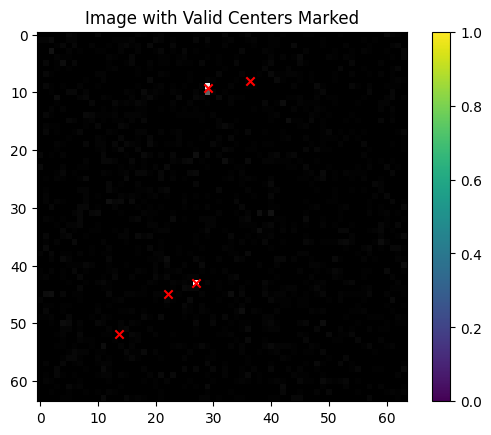

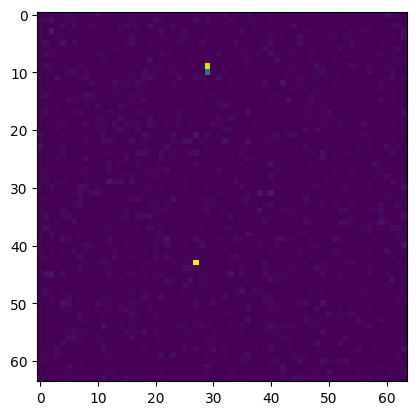

In [7]:
l=np.random.randint(0,len(centers))
data_loader.plot_image_with_centers(l)
plt.imshow(images[l])

In [8]:

# Normalize the data and split it into training and validation sets
train_images, val_images, train_midpoints, val_midpoints = data_loader.split_data()

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))


In [9]:

batch_size = 500
train_dataset = train_dataset.shuffle(buffer_size=8000, reshuffle_each_iteration=True).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=8000).batch(batch_size)

# Check the shape of the datasets
print(f'Train Images: {train_images.shape}, Train Midpoints: {train_midpoints.shape}')
print(f'Validation Images: {val_images.shape}, Validation Midpoints: {val_midpoints.shape}')


Train Images: (56000, 64, 64), Train Midpoints: (56000, 1, 5, 2)
Validation Images: (14000, 64, 64), Validation Midpoints: (14000, 1, 5, 2)


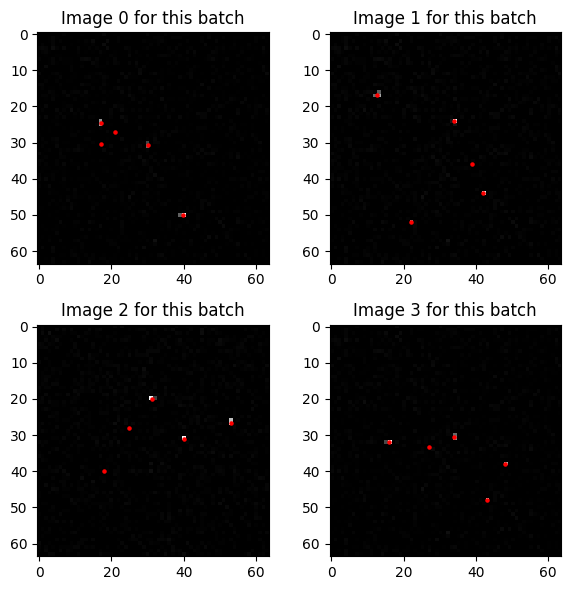

In [10]:
plot_transposed_images_with_midpoints(train_dataset, image_indices=[0, 1, 2, 3])

In [18]:


# Set up learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.9, patience=10, verbose=1, mode='min', min_lr=3e-5
)


In [11]:

# dynamic_exponent_callback = DynamicExponentCallback(1, 1, 50)


with strategy.scope():
    # Instantiate the model builder
    # model_builder = ModelBuilder(weights_path= "/home/da886/Weights from Josh's model/Josh's5fixedMSE45overfit-1.keras")
    model_builder = ModelBuilder()

    # Build the model
    model_builder.build_model()

    # Display the model architecture
    model_builder.model.summary()

    # Compile the model using the custom loss function
    # model_builder.compile_model(loss_function=dynamic_exponent_callback.custom_loss(1))
    model_builder.compile_model(loss_function=tf.keras.losses.MeanSquaredError()) 
    





Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      2,368 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,464 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 22, 22,    │      2,080 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,624 │ conv2d_1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 22, 22,    │     32,832 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 22, 22,    │      2,320 │ conv2d_2[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 22, 22,    │      9,232 │ conv2d_5[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 22, 22,    │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 32)               │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 22, 22,    │      4,624 │ concatenate[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 22, 22,    │      4,640 │ conv2d_7[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 22, 22,    │     18,496 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 13, 13,    │     23,168 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 30976)     │          0 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 10816)     │          0 │ conv2d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 41792)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │ 10,699,008 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]     

 Total params: 10,824,426 (41.29 MB)

 Trainable params: 10,824,426 (41.29 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:

# Train the model with the custom callback
history = model_builder.train_model(
    train_dataset, 
    val_dataset, 
    epochs=1100,
    callbacks_list=None
)


Epoch 1/1100


2024-09-28 20:34:38.480009: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-09-28 20:34:38.499665: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-09-28 20:34:38.517434: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1727555678.541237 1782206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727555678.541346 1782218 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727555678.546716 1782211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727555678.594366 1782206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727555678.594384 1782211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727555678.594572 1782218 gpu_timer.c

  5/112 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.6820

W0000 00:00:1727555681.084486 1782208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727555681.087485 1782208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727555681.088328 1782208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727555681.089208 1782208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727555681.090157 1782208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727555681.091441 1782208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727555681.092556 1782208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727555681.093587 1782208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727555681.094739 1782208 gp

111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5936

2024-09-28 20:34:44.459980: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-09-28 20:34:44.460116: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-09-28 20:34:44.460310: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
W0000 00:00:1727555685.345433 1782197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727555685.348275 1782217 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727555685.348701 1782197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be re

112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - loss: 0.5921 - val_loss: 0.3658
Epoch 2/1100


2024-09-28 20:34:46.375783: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3221

2024-09-28 20:34:50.351137: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.3214 - val_loss: 0.2210
Epoch 3/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.2010 - val_loss: 0.1557
Epoch 4/1100


2024-09-28 20:34:55.291434: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.1470 - val_loss: 0.1265
Epoch 5/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.1218 - val_loss: 0.1109
Epoch 6/1100
111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1083

2024-09-28 20:35:07.560480: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.1082 - val_loss: 0.1012
Epoch 7/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0991 - val_loss: 0.0933
Epoch 8/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0915 - val_loss: 0.0856
Epoch 9/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0830 - val_loss: 0.0747
Epoch 10/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0735 - val_loss: 0.0690
Epoch 11/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0677 - val_loss: 0.0636
Epoch 12/1100


2024-09-28 20:35:29.595272: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0625 - val_loss: 0.0582
Epoch 13/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0576 - val_loss: 0.0536
Epoch 14/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0528 - val_loss: 0.0494
Epoch 15/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0487 - val_loss: 0.0460
Epoch 16/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0453 - val_loss: 0.0426
Epoch 17/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0421 - val_loss: 0.0398
Epoch 18/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0393 - val_loss: 0.0371
Epoch 19/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0369 - val_loss: 0.0351
Epoch 20/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0346 - val_loss: 0.0329
Epoch 21/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0326 - val_loss: 0.0309
Epoch 22/1100
111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0308

2024-09-28 20:36:16.282732: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0307 - val_loss: 0.0294
Epoch 23/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0292 - val_loss: 0.0277
Epoch 24/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0277 - val_loss: 0.0264
Epoch 25/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0264 - val_loss: 0.0253
Epoch 26/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0253 - val_loss: 0.0243
Epoch 27/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0243 - val_loss: 0.0232
Epoch 28/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0233 - val_loss: 0.0223
Epoch 29/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0225 - val_loss: 0.0216
Epoch 30/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0218 - val_loss: 0.0210
Epoch 31/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0211 - val_loss: 0.0205
Epoch 32/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0206 - val_loss: 0.0198
Epoch 33/1100
112/112 ━━

2024-09-28 20:37:43.050340: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0170 - val_loss: 0.0167
Epoch 45/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0169 - val_loss: 0.0166
Epoch 46/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0168 - val_loss: 0.0164
Epoch 47/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0167 - val_loss: 0.0163
Epoch 48/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0166 - val_loss: 0.0161
Epoch 49/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0164 - val_loss: 0.0165
Epoch 50/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0164 - val_loss: 0.0162
Epoch 51/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0164 - val_loss: 0.0161
Epoch 52/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0163 - val_loss: 0.0158
Epoch 53/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0163 - val_loss: 0.0160
Epoch 54/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0162 - val_loss: 0.0160
Epoch 55/1100
112/112 ━━

2024-09-28 20:40:41.058289: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0152 - val_loss: 0.0150
Epoch 87/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0151 - val_loss: 0.0149
Epoch 88/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0152 - val_loss: 0.0148
Epoch 89/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0151 - val_loss: 0.0148
Epoch 90/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0151 - val_loss: 0.0148
Epoch 91/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0151 - val_loss: 0.0148
Epoch 92/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0152 - val_loss: 0.0148
Epoch 93/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0151 - val_loss: 0.0146
Epoch 94/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0150 - val_loss: 0.0149
Epoch 95/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0150 - val_loss: 0.0148
Epoch 96/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0151 - val_loss: 0.0146
Epoch 97/1100
112/112 ━━

2024-09-28 20:46:31.938246: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0142 - val_loss: 0.0136
Epoch 173/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0142 - val_loss: 0.0138
Epoch 174/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0141 - val_loss: 0.0138
Epoch 175/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0141 - val_loss: 0.0138
Epoch 176/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0141 - val_loss: 0.0140
Epoch 177/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0141 - val_loss: 0.0138
Epoch 178/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0141 - val_loss: 0.0139
Epoch 179/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0141 - val_loss: 0.0140
Epoch 180/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0141 - val_loss: 0.0140
Epoch 181/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0141 - val_loss: 0.0138
Epoch 182/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0141 - val_loss: 0.0139
Epoch 183/1100

2024-09-28 20:58:09.861625: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0134 - val_loss: 0.0130
Epoch 343/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0133 - val_loss: 0.0131
Epoch 344/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0134 - val_loss: 0.0129
Epoch 345/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0134 - val_loss: 0.0130
Epoch 346/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0134 - val_loss: 0.0129
Epoch 347/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0134 - val_loss: 0.0132
Epoch 348/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0133 - val_loss: 0.0129
Epoch 349/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0134 - val_loss: 0.0131
Epoch 350/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0133 - val_loss: 0.0130
Epoch 351/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0133 - val_loss: 0.0131
Epoch 352/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0134 - val_loss: 0.0132
Epoch 353/1100

2024-09-28 21:21:20.032829: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0129 - val_loss: 0.0125
Epoch 685/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0128 - val_loss: 0.0126
Epoch 686/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0129 - val_loss: 0.0126
Epoch 687/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0128 - val_loss: 0.0125
Epoch 688/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0129 - val_loss: 0.0126
Epoch 689/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0129 - val_loss: 0.0125
Epoch 690/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0128 - val_loss: 0.0125
Epoch 691/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0129 - val_loss: 0.0125
Epoch 692/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0129 - val_loss: 0.0125
Epoch 693/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0129 - val_loss: 0.0127
Epoch 694/1100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0128 - val_loss: 0.0124
Epoch 695/1100

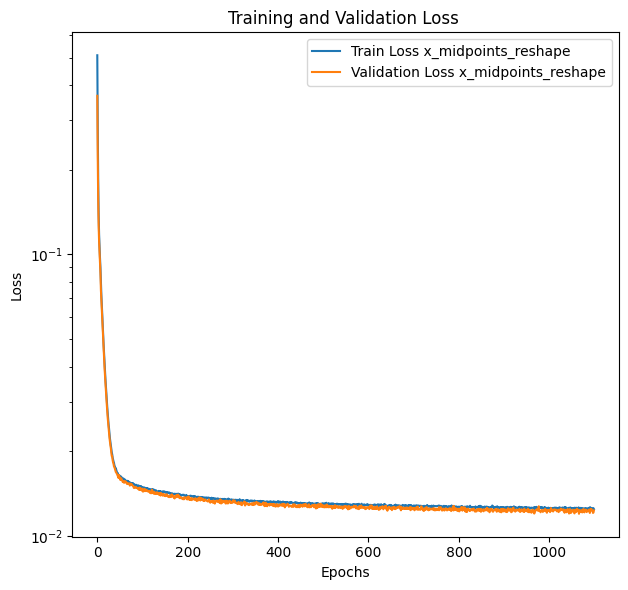

In [13]:


# Extract the losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']


train_loss_x_midpoints = history.history.get('x_midpoints_reshape_loss', train_loss)
val_loss_x_midpoints = history.history.get('val_x_midpoints_reshape_loss', val_loss)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2,1)
plt.plot(train_loss_x_midpoints, label='Train Loss x_midpoints_reshape')
plt.plot(val_loss_x_midpoints, label='Validation Loss x_midpoints_reshape')
plt.xlabel('Epochs')
plt.yscale('log')

plt.ylabel('Loss')
plt.title('Training and Validation Loss ')
plt.legend()

plt.tight_layout()
plt.show()


In [27]:
# model_builder.model.save("mynew5fixedMSE.keras")
# loaded_model = tf.keras.models.load_model(
# "/home/da886/Weights from Josh's model/Josh's5fixedCustomRegularized.keras",
# )

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the function for visualizing midpoints
def visualize_midpoints(image, midpoints, title="Predicted Midpoint Visualization"):
    """
    Visualizes midpoints on an image without using a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - title: The title of the plot.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    midpoints_np = midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title(title)

    # Plot midpoints directly, only if they are not (0, 0)
    for i, (x, y) in enumerate(midpoints_np):
        if x >= 3 and y >= 3:  # Only plot if the point is not (0, 0)
            plt.scatter(x, y, color='red', s=5)

    plt.show()

# Create the validation dataset
# val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))
# val_dataset = val_dataset.batch(800)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
train_dataset = train_dataset.batch(800)
# inputs,targets = next(iter(train_dataset))
# outputs = model_builder.model.predict(inputs)
# # Initialize lists to collect the data
all_images = []
all_true_midpoints = []
all_pred_midpoints = []

# # Loop through each batch in the validation dataset, predict, and collect results
# for i, (data_batch, midpoints_batch) in enumerate(val_dataset):

for i, (data_batch, midpoints_batch) in enumerate(train_dataset):
    print(f"Processing batch {i + 1}, batch shape: {data_batch.shape}")
    
    # Get the model predictions
    predictions = model_builder.model.predict(data_batch)

    # Extend the lists to store data from each batch
    all_images.extend(data_batch.numpy())  # Store all images
    all_true_midpoints.extend(midpoints_batch.numpy())  # Store all true midpoints
    all_pred_midpoints.extend(predictions)  # Store all predicted midpoints

# Convert lists to arrays for easier indexing
all_images = np.array(all_images)
all_true_midpoints = np.array(all_true_midpoints)
all_pred_midpoints = np.array(all_pred_midpoints)


Processing batch 1, batch shape: (800, 64, 64)


W0000 00:00:1727632468.950829 1782207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727632468.951103 1782171 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727632468.951357 1782216 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727632468.960657 1782207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727632468.960782 1782171 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727632468.961142 1782207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727632468.962791 1782171 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727632468.963369 1782207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727632468.964187 1782216 gp

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step 


W0000 00:00:1727632469.152285 1782171 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727632469.152581 1782207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727632469.152604 1782216 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727632469.152831 1782171 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727632469.153284 1782207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727632469.153288 1782216 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727632469.153388 1782171 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727632469.153919 1782207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727632469.153945 1782216 gp

Processing batch 2, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Processing batch 3, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Processing batch 4, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Processing batch 5, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Processing batch 6, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   
Processing batch 7, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Processing batch 8, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Processing batch 9, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Processing batch 10, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Processing batch 11, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Processing batch 12, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Processing batch 13, batch s

In [15]:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
# train_dataset = train_dataset.batch(800)
# inputs,targets = next(iter(train_dataset))
# outputs = model_builder.model.predict(inputs)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [15]:
all_images.shape,all_pred_midpoints.shape,all_true_midpoints.shape

((56000, 64, 64), (56000, 1, 5, 2), (56000, 1, 5, 2))

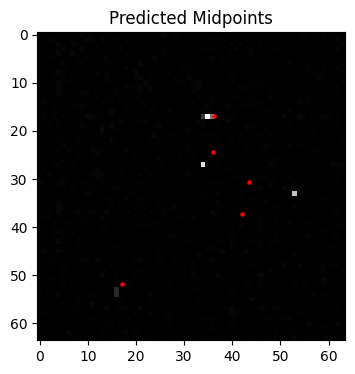

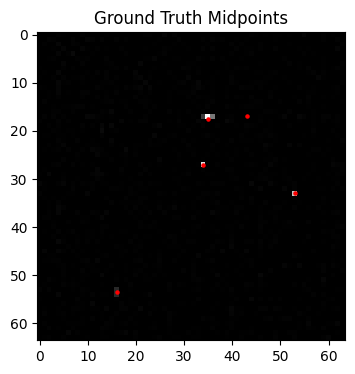

In [23]:

# Select an index to visualize from the entire dataset
index_to_visualize = np.random.randint(0, len(all_images))

# index_to_visualize = 11548
# Visualize the selected image with predicted and true midpoints
visualize_midpoints(all_images[index_to_visualize], all_pred_midpoints[index_to_visualize, 0, :, :] * 64, title="Predicted Midpoints")
visualize_midpoints(all_images[index_to_visualize], all_true_midpoints[index_to_visualize, 0, :, :] * 64, title="Ground Truth Midpoints")


In [23]:
model_builder.model.evaluate(val_dataset)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0867


0.08695701509714127

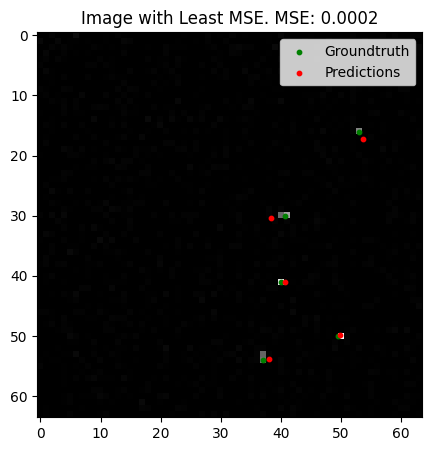

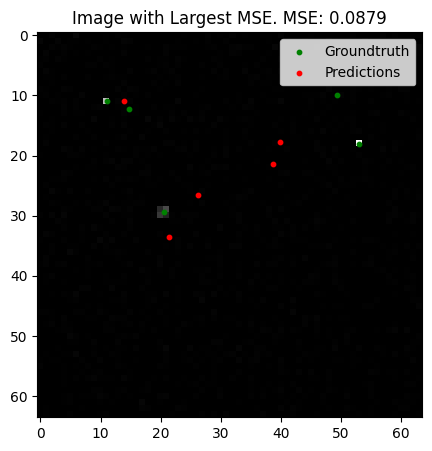

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize variables to track the min and max MSE
min_mse = float('inf')
max_mse = float('-inf')
min_mse_index = -1
max_mse_index = -1

# Loop through each prediction to calculate the MSE
for i in range(len(all_pred_midpoints)):
    mse = np.mean((all_pred_midpoints[i] - all_true_midpoints[i]) **2)
    
    if mse < min_mse:
        min_mse = mse
        min_mse_index = i
    
    if mse > max_mse:
        max_mse = mse
        max_mse_index = i
import numpy as np
import matplotlib.pyplot as plt

# Function to plot an image with its centers
def plot_image_with_centers(image, true_center, predicted_center, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze(), cmap='gray')  # Display the image

    # Plot the actual center (Groundtruth)
    plt.scatter(true_center[:, 0], true_center[:, 1], color='green', label='Groundtruth', s=10)

    # Plot the predicted center
    plt.scatter(predicted_center[:, 0], predicted_center[:, 1], color='red', label='Predictions', s=10)

    plt.title(title)
    plt.legend()
    plt.show()






# Plotting the image with the least MSE
plot_image_with_centers(all_images[min_mse_index],
                        all_true_midpoints[min_mse_index][0] * 64,  # Adjust for scaling if needed
                        all_pred_midpoints[min_mse_index][0] * 64,  # Adjust for scaling if needed
                        f'Image with Least MSE. MSE: {min_mse:.4f}')

# Plotting the image with the largest MSE
plot_image_with_centers(all_images[max_mse_index],
                        all_true_midpoints[max_mse_index][0] * 64,  # Adjust for scaling if needed
                        all_pred_midpoints[max_mse_index][0] * 64,  # Adjust for scaling if needed
                        f'Image with Largest MSE. MSE: {max_mse:.4f}')




In [263]:
max_mse_index

11548